In [4]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define directories
source_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/thermal images UL"
output_directory = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal_dataset/processed_data_Unet"

# Create output directory if it doesn’t exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List class folders in source
classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']
print("Classes:", classes)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [7]:
import cv2
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation transformations
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Process each class
for class_name in classes:
    source_class_path = os.path.join(source_directory, class_name)
    output_class_path = os.path.join(output_directory, class_name)

    # Create output class directory
    if not os.path.exists(output_class_path):
        os.makedirs(output_class_path)

    # Loop through images in the class folder
    for img_name in os.listdir(source_class_path):
        img_path = os.path.join(source_class_path, img_name)

        # Read the image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping {img_name}, unable to read.")
            continue

        # Resize to 224x224 (for R-CNN)
        image = cv2.resize(image, (224, 224))

        # Save original image
        output_img_path = os.path.join(output_class_path, img_name)
        cv2.imwrite(output_img_path, image)

        # Apply augmentation (generate 3 variations per image)
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        i = 0
        for batch in datagen.flow(image, batch_size=1, save_to_dir=output_class_path, save_prefix='aug', save_format='jpg'):
            i += 1
            if i >= 3:  # Limit to 3 augmented images
                break

print("✅ Image processing and augmentation completed.")


✅ Image processing and augmentation completed.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators (with 20% validation split)
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    output_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    output_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")


Found 2744 images belonging to 9 classes.
Found 681 images belonging to 9 classes.
Training samples: 2744
Validation samples: 681


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load VGG16 model (without top layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create model
model = Model(inputs=base_model.input, outputs=x)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 17,934,921 (68.42 MB)

 Trainable params: 3,220,233 (12.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 438s 5s/step - accuracy: 0.2889 - loss: 1.9144 - val_accuracy: 0.4302 - val_loss: 1.6739
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 225ms/step - accuracy: 0.5243 - loss: 1.3950 - val_accuracy: 0.5154 - val_loss: 1.5031
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 218ms/step - accuracy: 0.6420 - loss: 1.1365 - val_accuracy: 0.5742 - val_loss: 1.3355
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.7060 - loss: 0.9354 - val_accuracy: 0.5419 - val_loss: 1.3693
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 214ms/step - accuracy: 0.7905 - loss: 0.7842 - val_accuracy: 0.4581 - val_loss: 1.3624
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.7982 - loss: 0.7108 - val_accuracy: 0.5624 - val_loss: 1.2675
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.8377 - loss: 0.6299 - val_accuracy: 0.5888 - val_loss: 1.1746
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - accuracy: 0.8549 - loss: 0.5631 - val_accura

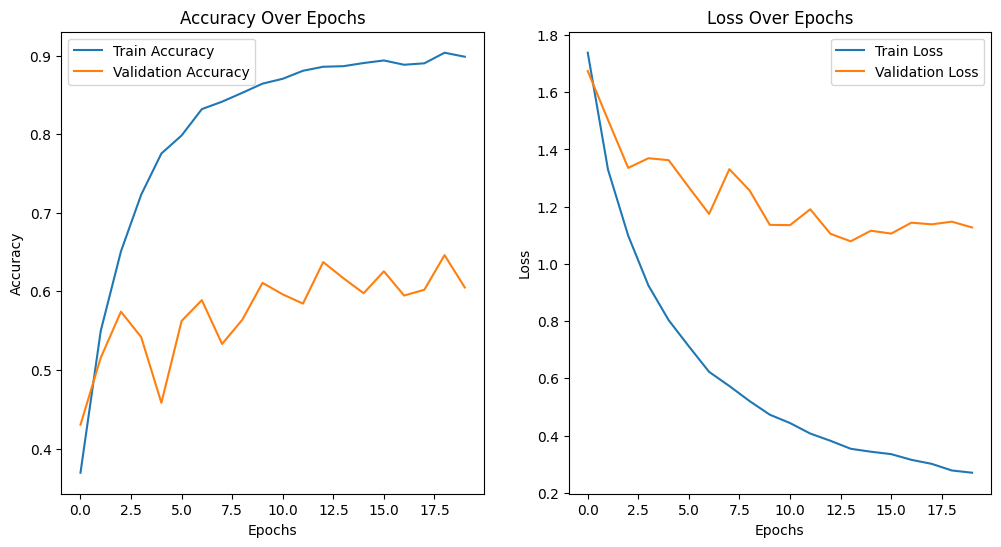

In [10]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot results
plot_training_history(history)
